In [10]:
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive           # read/write to/from SciDrive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import skimage.io                   # image processing library
import urllib                       # accessing resources thorugh remote URLs
import json                         # work with JSON files

from pymongo import MongoClient
from bson.son import SON
import astropy.io.fits as astrofits
from astropy.table import Table, Column, join

verbose = True
if verbose :
    from IPython.display import display, HTML
    import pprint
    prettyPrinter = pprint.PrettyPrinter(indent=4)


In [2]:
#authentication stuff
authToken = 'dd222841556f44a88b1eb08269070140'
import SciServer.LoginPortal
userManager = SciServer.LoginPortal.getKeystoneUserWithToken(authToken)


#select whatever data you want, you can see what else is available here https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+SpecPhoto+V

In [3]:
#Selecting data from galaxies within this redshift range 0,001 < z < 0.013
redShiftMaximum = 0.013
redShiftMinimum = 0.001

galaxyTypeInt = 3  # could look up from table in principle
sdssDR12Query = """SELECT s.objID,
s.ra, 
s.dec,
s.type,
s.petromag_r,
s.modelMag_u,
s.modelMag_g,
s.modelMag_r,
s.modelMag_i,
s.modelMag_z,
s.z as redShift,
s.zErr as redshiftUncertainty,
s.zWarning as redShiftWarning,
dbo.fSpecZWarningN(zWarning) as redShiftWarningText,
g.petror90_r
FROM SpecPhoto AS s
JOIN Galaxy AS g 
ON s.objID = g.objID
WHERE (s.type = """ + str(galaxyTypeInt) + " AND s.z < " + str(redShiftMaximum) + " AND s.z > " + str(redShiftMinimum) + " AND s.zWarning = 0)"

In [4]:
sdssDR12Response = CasJobs.executeQuery(sdssDR12Query, "dr12",token=authToken)


In [5]:
#write table
sdssDR12Response.to_csv('ferengi_candidates.csv')

In [7]:
print 'The number of galaxies in SDSS DR12 with z < 0.013 is %i'%len(sdssDR12Response)

The number of galaxies in SDSS DR12 with z < 0.013 is 6101


## The 6,101 galaxies above were first reduced by placing a magnitude cut on petromag_r < 17, to match that used by GZ2. This produced 4,051 galaxies. Of these, 1,962 had J mag data from 2MASS. These were matched via CASJobs, details in my GZHubble google doc. I then found Galex matches for these (details again in GZHubble google doc). These are matched on position, and thus there were often multiple Galex matches for any single SDSS galaxy. This gave a table of 3,762 objects. Here we will extract the appropriate NUV mags for unique SDSS galaxies. 

In [42]:
data = Table.read('new_ferengi_color_data.fits')
len(data)

3762

In [3]:
unique_galaxies = set(data['dr12objid'])

In [4]:
len(unique_galaxies)

1645

In [5]:
set_list = []
for sdss_id in unique_galaxies:
    gals = data[data['dr12objid']==sdss_id]
    set_list.append(len(gals))

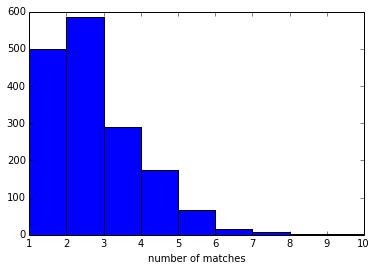

In [6]:
plt.hist(set_list,range=(0,10))
plt.xlabel('number of matches')

In [7]:
#The majority of ferengi candidates had 1-2 Galex matches. Now to see if the multiple matches have the same NUV mags.
nuv_std_list=[]
multiple_matches = data[data['GroupID']>0] #only data with multiple matches
group_ids = set(multiple_matches['GroupID'])
for group in group_ids:
    this_group = data[data['GroupID']==group]
    nuv_mags = this_group['nuv_mag'] #all nuvs for same SDSS ID. See if they're similar.
    nuv_std_list.append(np.std(nuv_mags))

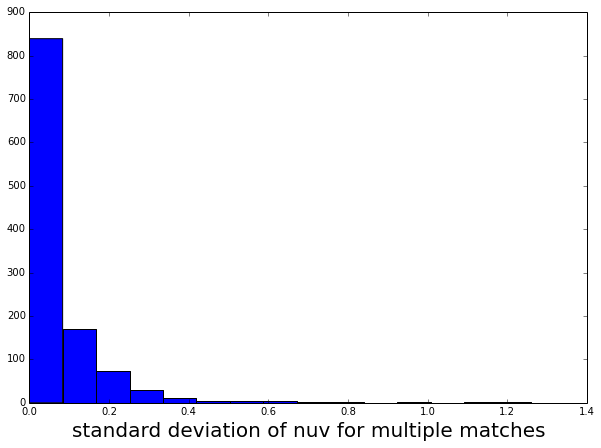

In [8]:
f=plt.figure(figsize=(10,7))
plt.hist(nuv_std_list,bins=15)
plt.xlabel('standard deviation of nuv for multiple matches',fontsize=20)

OK so for most of the multiple matches, the nuv mags are within ~0.1 mags. Let's keep galaxies with standard deviations < 0.5, and take the average value for the one we use. 

In [ ]:
#create table of sdss ids and nuv mags
#remove all galex columns from original table
#join on new table

In [15]:
sdss_id_list=[] #list of sdss_ids
nuv_mag_list=[] #list of corresponding nuv mags
for sdss_id in unique_galaxies:
    gals = data[data['dr12objid']==sdss_id] #pick out galaxies with same sdss id
    if len(gals)==1: #if there are no multiple matches, copy ID and nuv mag straight into list
        sdss_id_list.append(sdss_id)
        nuv_mag_list.append(gals['nuv_mag'][0])
    else: #there are multiple matches for one galaxy
        nuv_mags = gals['nuv_mag'] #all nuv_mags for same(?) galaxy
        if np.std(nuv_mags)<0.5: #nuv_mags are within 0.5 of each other, on average
            sdss_id_list.append(sdss_id)
            nuv_mag_list.append(np.mean(nuv_mags))

In [40]:
#Table of sdss_ids and nuv_mags
c1 = Column(sdss_id_list,name='dr12objid')
c2 = Column(nuv_mag_list,name='nuv_mag') 
nuv_table = Table()  
nuv_table.add_columns([c1,c2])


In [43]:
all_data_table = data.copy(copy_data=True)
all_data_table.remove_column('galexid')
all_data_table.remove_column('nuvExposureTime')
all_data_table.remove_column('fuvExposureTime')
all_data_table.remove_column('nuv_mag')
all_data_table.remove_column('nuv_magErr')
all_data_table.remove_column('fuv_mag')
all_data_table.remove_column('fuv_magErr')
all_data_table.remove_column('e_bv')
all_data_table.remove_column('sdss_id')


In [62]:
#JOINED IN TOPCAT BECAUSE NOT WORKING IN PYTHON. only want unique galaxies from nuv_table. 
#new_ferengi_table=join(all_data_table, nuv_table, keys='dr12objid')

In [65]:
fdata = Table.read('new_ferengi_candidates.fits')


In [67]:
len(fdata)

1628

In [66]:
red_sequence = fdata[(fdata['nuv_mag']-fdata['modelMag_r']>3.1)]
blue_cloud = fdata[(fdata['nuv_mag']-fdata['modelMag_r']<3.1)]


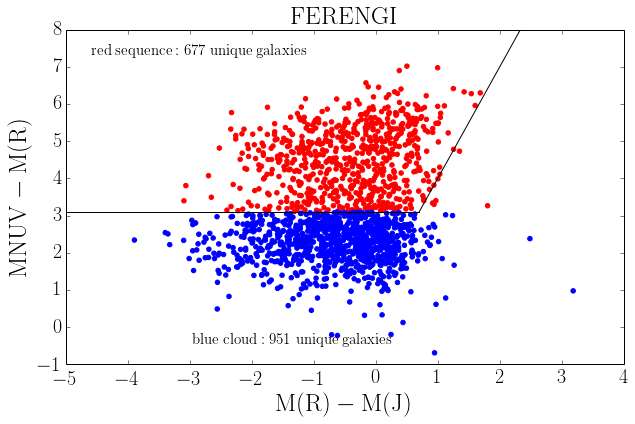

In [78]:
plt.rcParams['text.usetex']=True
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20 

f=plt.figure(figsize=(10,6))

x1=np.linspace(-5,.7,100)
x2=np.linspace(.7,5,100)

plt.plot(x1,3.1+0*x1,c='k')
plt.plot(x2,3*x2+1,c='k')

plt.scatter(red_sequence['modelMag_r']-red_sequence['j'],red_sequence['nuv_mag']-red_sequence['modelMag_r'],color='r')
plt.scatter(blue_cloud['modelMag_r']-blue_cloud['j'],blue_cloud['nuv_mag']-blue_cloud['modelMag_r'],color='b')

plt.xlim(-5,4)
plt.ylim(-1,8)
plt.ylabel('$\mathrm{MNUV-M(R)}$',fontsize=25)
plt.xlabel('$\mathrm{M(R)-M(J)}$',fontsize=25)
f.text(.16,.84,r'$\mathrm{red~sequence:%i~unique~galaxies}$'%len(red_sequence),fontsize=15)
f.text(.3,.17,r'$\mathrm{blue~cloud:%i~unique~galaxies}$'%len(blue_cloud),fontsize=15)
plt.title('$\mathrm{FERENGI}$',fontsize=25)

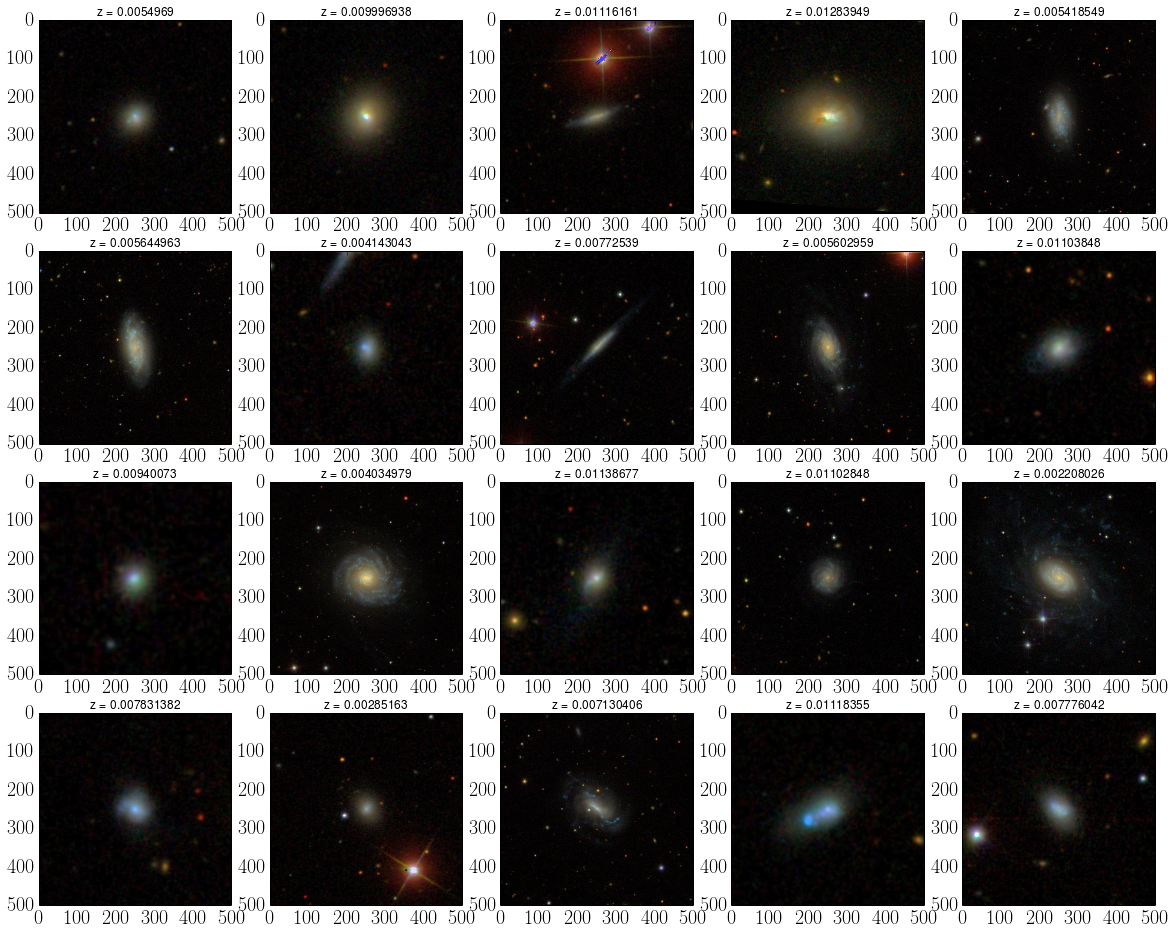

In [88]:
pixelsize=0.396
height=500
width=500

# figures do not persist between cells!
plt.figure(figsize=(20, 20))
subPlotNum = 1

for i in range(0,20):
    galaxy = blue_cloud[i]
    # the 'scale' parameter is set so that the image will be about 2x the size of the galaxy
    scale=4.0*galaxy['petror90_r']/pixelsize/width
    # form wurl to query SDSS web sevice to generate cutout image
    cutOutImageUrl="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=" + str(galaxy['RA'])
    cutOutImageUrl += "&dec=" + str(galaxy['DEC']) + "&scale=""" + str(scale) + "&width=" + str(width)
    cutOutImageUrl += "&height=" + str(height)
    # retrieve 
    cutoutImage=skimage.io.imread(cutOutImageUrl)
    plt.subplot(5,5,subPlotNum)
    subPlotNum += 1
    plt.imshow(cutoutImage)
    # show the object identifier (objId) above the image.
    plt.title("z = " + str(galaxy['redShift']))

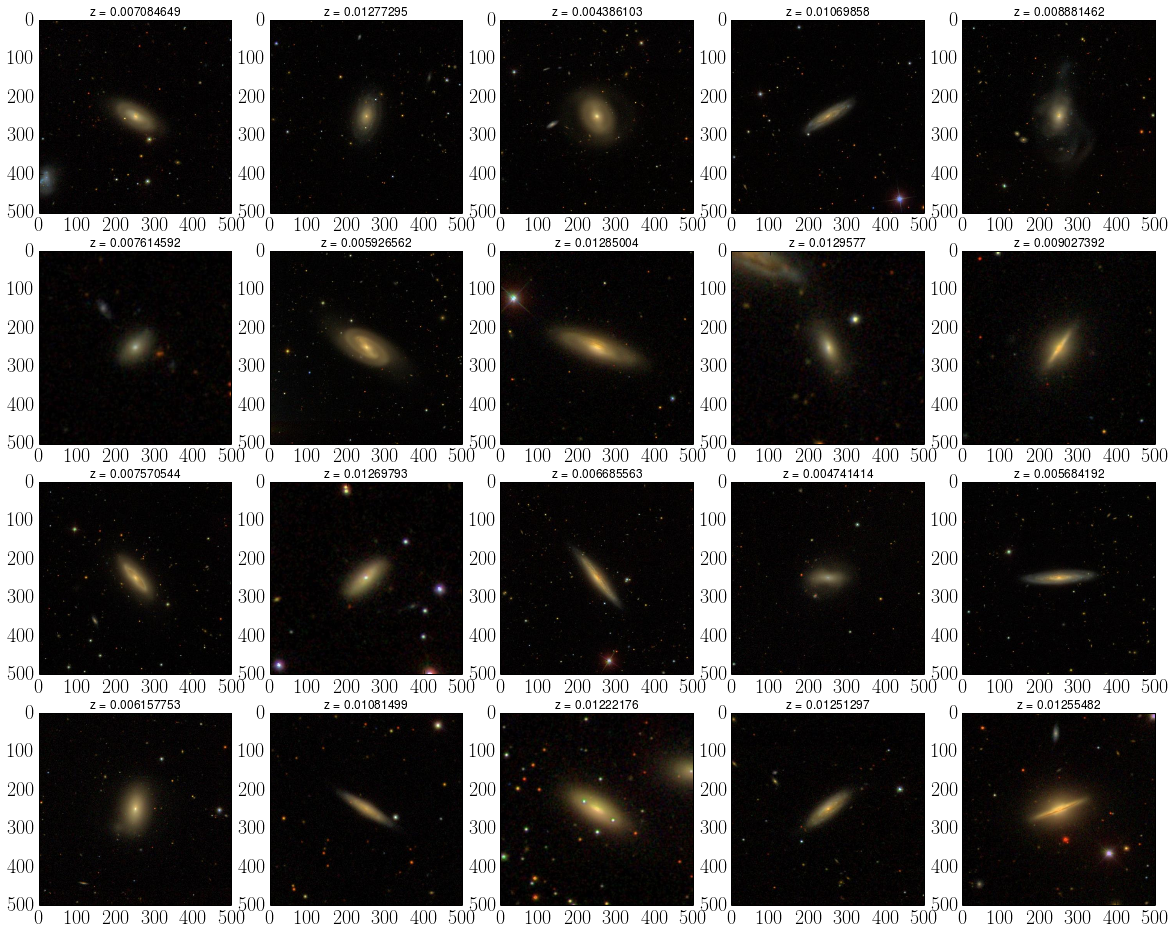

In [89]:
pixelsize=0.396
height=500
width=500

# figures do not persist between cells!
plt.figure(figsize=(20, 20))
subPlotNum = 1

for i in range(0,20):
    galaxy = red_sequence[i]
    # the 'scale' parameter is set so that the image will be about 2x the size of the galaxy
    scale=4.0*galaxy['petror90_r']/pixelsize/width
    # form wurl to query SDSS web sevice to generate cutout image
    cutOutImageUrl="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=" + str(galaxy['RA'])
    cutOutImageUrl += "&dec=" + str(galaxy['DEC']) + "&scale=""" + str(scale) + "&width=" + str(width)
    cutOutImageUrl += "&height=" + str(height)
    # retrieve 
    cutoutImage=skimage.io.imread(cutOutImageUrl)
    plt.subplot(5,5,subPlotNum)
    subPlotNum += 1
    plt.imshow(cutoutImage)
    # show the object identifier (objId) above the image.
    plt.title("z = " + str(galaxy['redShift']))

In [92]:
galaxy = blue_cloud[18]
cutOutImageUrl="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=" + str(galaxy['RA'])
cutOutImageUrl += "&dec=" + str(galaxy['DEC']) + "&scale=""" + str(scale) + "&width=" + str(width)
cutOutImageUrl += "&height=" + str(height)

cutOutImageUrl

'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=233.5557&dec=57.28532&scale=0.422313131313&width=500&height=500'

In [75]:
cool = visible[visible['objID']==1237651539794526301]

In [84]:
    cutOutImageUrl="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=" + str(cool['ra'][0])
    cutOutImageUrl += "&dec=" + str(cool['dec'][0]) + "&scale=""" + str(scale) + "&width=" + str(width)
    cutOutImageUrl += "&height=" + str(height)


In [83]:
cool = visible[visible['objID']==1237661871864545390]

In [86]:
450*.01+450

454.5